<a href="https://colab.research.google.com/github/Jaesu26/aifactory-water-demand-forecasting/blob/main/2022-12-05-%EB%86%8D%EC%B4%8C%EC%A7%80%EC%97%AD-%EC%88%98%EB%8F%97%EB%AC%BC-%EC%88%98%EC%9A%94%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [2022 제2회 K-water AI 경진대회] 수돗물 수요예측 AI 알고리즘 개발

- [2022-Task 2] 아포 : 경상북도 김천시 아포읍

## 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pickle
import random
import math
import os
import gc

import statsmodels.graphics.tsaplots as sgt

from typing import Any, Dict, List, Optional, Tuple, Union
from numpy.typing import NDArray
from easydict import EasyDict

from tqdm.auto import tqdm
from glob import glob

warnings.filterwarnings('ignore') 

In [2]:
from google.colab import drive

drive.mount('/content/drive')  ## 구글코랩과 구글드라이브 연결

Mounted at /content/drive


In [3]:
%cd  /content/drive/MyDrive/Colab Notebooks/농촌지역-수돗물-수요예측

/content/drive/MyDrive/Colab Notebooks/농촌지역-수돗물-수요예측


- 데이터 불러오기

In [4]:
train_path = './data/data_tr_apo.csv'
test_path = './data/data_ts_apo.csv'
submission_path = './data/sample_apo.csv'

In [27]:
df = pd.read_csv(train_path)
test = pd.read_csv(test_path)
submission = pd.read_csv(submission_path)

In [28]:
# 변수 이름을 영문으로 변경
df = df.rename(columns={'구미 아포배수지 유출유량 적산차':'flow'})
test = test.rename(columns={'구미 아포배수지 유출유량 적산차':'flow'})


# 날짜를 datetime 형식으로 변경
df['datetime'] = pd.to_datetime(df['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

In [29]:
test2 = test.copy()

- 가중치 저장폴더

In [8]:
def create_folder(path: str) -> None:
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError as error:
        print(error)

- 데이터 설명

`-` 유량: 단위시간 당 얼마만큼의 체적에 해당하는 액체가 이동했는지 나타냄 ($m^3/h$)

`-` 적산값: 1시간마다 측정한 값이 계속 누적 (i.g. $100 \xrightarrow{~+170~} 270 \xrightarrow{~+150~} 420 \xrightarrow{~+110~} 530$)  

`-` 적산차값: 적산의 매시간 차이를 계산 ($\approx$ 시간 단위 공급량,$\quad$ i.g. $\operatorname{NA},170, 150, 110$)

## 전처리

`-` 데이터는 항상 시간상의 순서대로 존재해야 한다

`-` 데이터에서 특정 시점의 적산차값이 결측치일 수도 있지만 특정 시점 자체가 누락되면 안된다 

`-` 그래프에 추세는 없어보인다

`-` 데이터에 결측치가 존재한다

`-` 결측치는 계절성을 고려하여 전날 같은 시각의 적산차값으로 채워주자

`-` 이상치가 존재한다 (예컨대 음수 또는 매우 큰 양수)

`-` 로그 변환

`-` 후처리는 반올림

- 이상치와 결측치 처리

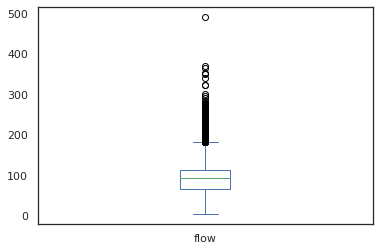

In [30]:
df.query('0 < flow < 500').flow.plot.box()

`-` 100,000을 넘기는 매우 큰 값이 존재한다

`-` 또한, 음수값도 존재하는데 이들은 모두 -100,000보다 작다

`-` 위와 같은 경우는 계측기에 문제가 있는 것으로 보인다

`-` 0인 경우도 존재한는데 계측기의 오류 또는 모종의 이유로 물이 흐르지 않은 것으로 보인다 (i.g. 배수지 청소로 인해 단수)

`-` 이런 경우 적산차값만 사용해 예측하는 것은 불가능하므로 이상치로 처리하겠다  

`-` 한편, 큰 양수의 경우 이상치의 기준은 300을 넘지 않는 값 중 최댓값으로 하겠다 (위의 box-plot에 기반함, IQR을 넘는 값들을 보면 300부터 절단되어 빈도수가 매우 작아짐)

`-` 이상치와 결측치는 계절성을 고려하여 전날 같은 시각의 적산차값으로 대체하겠다

In [9]:
def fillna(time_series: pd.Series, m: int = 24) -> pd.Series:
    """m 시점 앞의 값으로 결측치를 재귀적으로 채우고 데이터를 반환"""
    assert time_series.ndim == 1
    time_series = time_series.copy()  # 원본이 변하지 않도록 복제 
    na_idx = time_series[time_series.isnull()].index.values
    fill_idx = na_idx - m  # m 시점 앞의 값으로 결측치를 채운다
    fill_idx = np.where(fill_idx < 0, fill_idx + m, fill_idx)

    if not na_idx.size:                  # 결측치가 존재하지 않으면 원본을 반환
        return time_series
    if np.in1d(fill_idx, na_idx).all():  # m 시점 앞의 값이 결측치면 원본을 반환
        return time_series

    time_series[na_idx] = time_series[fill_idx]
    return fillna(time_series, m)

In [31]:
# 이상치는 결측치로 처리한다
tmp = df.flow[df.flow < 300].max()
df['flow'] = df['flow'].apply(lambda x: x if 0 < x <= tmp else np.nan)
test2['flow'] = test2['flow'].apply(lambda x: x if 0 < x <= tmp else np.nan)

In [32]:
# 결측치는 계절성을 고려하여 전날 같은 시각의 적산차값으로 채운다 
df['flow'] = fillna(df['flow']).fillna(method='ffill').fillna(0)
test2['flow'] = fillna(test2['flow']).fillna(method='ffill').fillna(0)

## 시각화

In [33]:
sns.set_theme(style='white')

In [34]:
# 연도별 적산차의 분포
df.assign(year = df.datetime.dt.year).\
groupby('year').flow.describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2017,8759.0,94.024775,39.571984,3.0,66.0,89.0,115.0,273.0
2018,8760.0,102.328196,48.151006,4.0,68.0,93.0,113.0,296.0
2019,8760.0,98.975000,48.606899,15.0,63.0,91.0,109.0,283.0
2020,8784.0,101.714253,49.576752,4.0,64.0,94.0,113.0,273.0


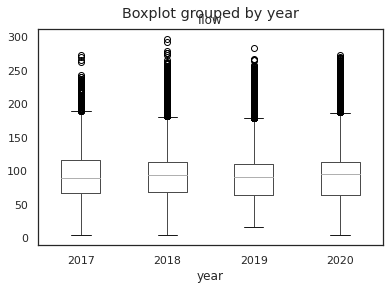

In [35]:
# 연도별 적산차의 분포
df.assign(year = df.datetime.dt.year).boxplot(column='flow', by='year', grid=False)

`-` 적산차의 경우 2017년과 나머지 연도는 다른 분포를 띄고있다 (평균과 분산이 더 커졌다)

`-` 원인은 200을 넘어가는 큰 값의 빈도수에 있다 (배수지를 증설한 듯 하다)

`-` 모델 훈련에 2017년 데이터를 사용하지 않는게 미래를 예측하는데 더 나을 수 있다

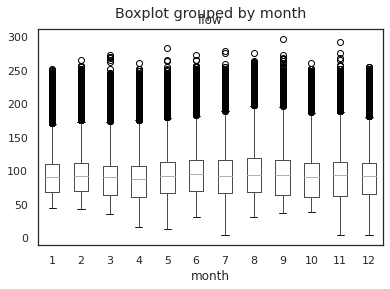

In [36]:
# 월별 적산차의 분포
df.assign(month = df.datetime.dt.month).boxplot(column='flow', by='month', grid=False)

`-` 8월의 수돗물 수요가 평균적으로 가장 많다

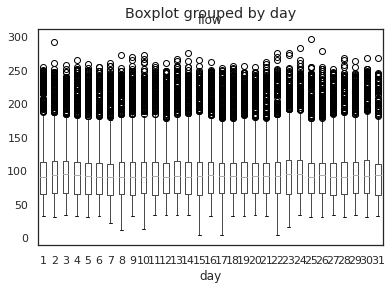

In [37]:
# 일별 적산차의 분포
df.assign(day = df.datetime.dt.day).boxplot(column='flow', by='day', grid=False)

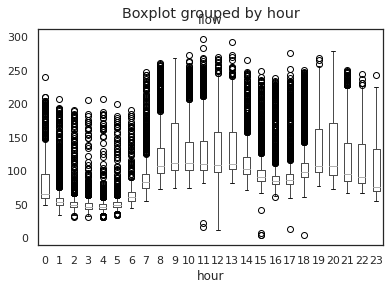

In [38]:
# 시간별 적산차의 분포
df.assign(hour = df.datetime.dt.hour).boxplot(column='flow', by='hour', grid=False)

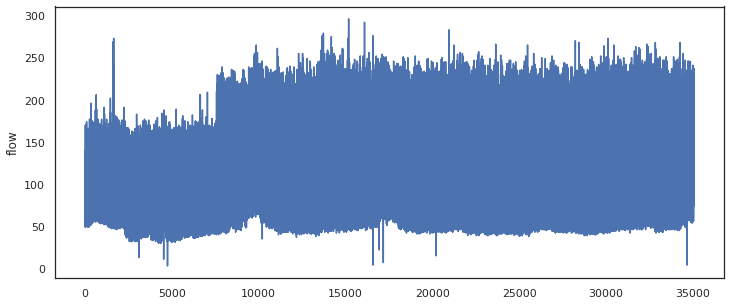

In [39]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.lineplot(data=df['flow'], ax=ax)

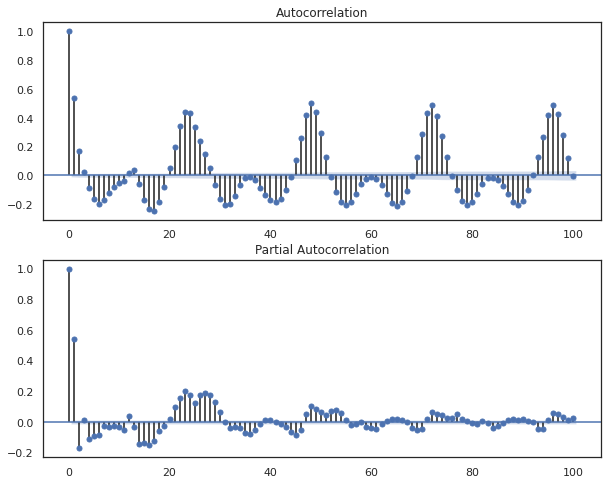

In [40]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
sgt.plot_acf(df['flow'], lags = 100, ax=ax1);
sgt.plot_pacf(df['flow'], lags = 100, ax=ax2);

`-` 그래프에 2017년을 제외하면 추세는 존재하지 않고 강한 계절성이 존재한다

`-` ACF, PACF의 정의에 따라 0시점 차이는 의미가 없으므로 무시한다

`-` 계절성이 매우 강하다 (6시간, 18시간, 24시간, 1주, 1달, 1년 등)

`-` 신기한 것은 12시점(12시간)차이의 경우 자기상관이 존재하지 않는다

`-` 사이클(W 모양)이 대략 24시간 마다 반복되므로 최소 24시간 분량의 변수를 모델의 입력으로 사용해야 한다

- 추가 설명

`-`  hello 라는 단어를 생각해보자, 다음의 같은 사이클이 반복된다

`-` h $\to$ e, e $\to$ l, l $\to$ l, l $\to$ o, o $\to$ h 

`-` 만약 단어 하나만이 입력으로 주어진다면 l이 입력으로 들어왔을 때 다음에 오는 단어가 l인지 o인지 알 수 없다

`-` 하지만 연속된 단어 두개가 입력으로 주어진다면 다음에 올 단어를 예측할 수 있다

`-` 예컨대 ll 이면 o, lo 이면 h이다

`-` 이는 적산차를 예측하는 문제에서도 마찬가지이다

- 고점 판단

`-` 시각화하면 알 수 있는데 고점은 하루에 2번 나타난다 (9시 부근, 20시 부근, 나머지는 잡음으로 생각)

In [41]:
high_value = np.quantile(df['flow'].values, q=1-2/24)  # 하루에 고점은 2번 (시각화로 확인함)

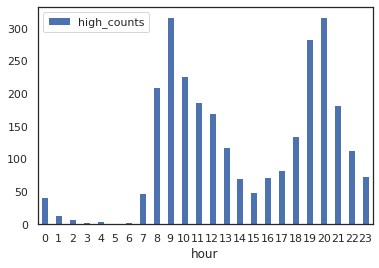

In [42]:
df.assign(year = df.datetime.dt.year).query('year > 2017').\
assign(is_high = (df.flow > high_value).astype(int)).\
assign(hour = df.datetime.dt.hour).\
groupby('hour').agg(high_counts=('is_high', np.sum)).\
reset_index().plot.bar(x='hour', y='high_counts', rot=0)

`-` 모델 학습에서 가장 큰 문제점은 고점이 언제인지 판단하는 것이다

`-` 고점이 언제 나타날지 불명확하기에 맞추기 어렵다

`-` 고점을 틀렸을 때 손실을 생각하면 맞추지 않는게 낫기에 모델은 고점을 전혀 잡아내지 못한다

`-` 즉, 모델은 고점을 잡음으로 취급한다

## 딥러닝 모델 학습

In [17]:
# !git clone https://github.com/ts-kim/RevIN.git

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
from torch.nn.modules.loss import _Loss
from torch.optim import Optimizer
from torch.autograd import Variable

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

from RevIN.RevIN import RevIN

- base score

In [43]:
tmp = df['flow'].values
m = 48
mean_absolute_error(tmp[m:], tmp[:-m])

26.555818934742252

In [44]:
mean_absolute_error(df['flow'].values[m:], df['flow'].ewm(span=2).mean().values[:-m])

25.772675330276037

- 학습 방법

`-` private 데이터는 2022-01-01-00:00:00 부터 존재할 것이다

`-` public 데이터는 2021-12-17 23:00:00 까지 존재한다

`-` 2021-12-17 23:00:00 에서 337시간 뒤는 2022-01-01 00:00:00 이다

`-` 337시간 후의 적산차를 예측하는 모델을 만드는게 적합하지만 그러면 시간상의 차이가 많이 나서 성능이 떨어진다

`-` 따라서 1시간 후의 적산차를 예측하는 모델을 만들고 존재하지 않는 시각의 정보는 예측한 정보로 대체하여 사용하겠다

`-` 1시간 후의 적산차를 예측하기 위해 pacf 그래프에 근거해 24시간의 배수에 해당하는 분량을 사용하겠다

`-` 사이클을 포함하는(24시간 이상) 시계열 중 24시간 차이가 나는 데이터간의 직접적인 상관관계가 가장 크다

`-` 하나의 사이클을 포함하면서 과적합을 피하기 위해 336시간 분량을 사용하겠다

- 전처리

In [21]:
def ts_train2supervised(
    ts: NDArray[np.float_], 
    window: int = 24,
    gap: int = 1, 
    step: int = 336
) -> Tuple[NDArray[np.float_], NDArray[np.float_]]:
    assert ts.ndim == 2 and ts.shape[1] == 1
    X, y = [], []
    for t in range(len(ts) - (window+gap+step) + 2):
        X.append(ts[t:t+window])
        y.append(ts[t+window+gap-1 : t+window+gap+step-1])
    X, y = np.array(X), np.array(y)  
    return X, y

`-` 예측을 위해 train과 test를 병합 

In [22]:
def ts_test2supervised(
    ts: NDArray[np.float_], 
    window: int = 24
) -> NDArray[np.float_]:
    assert ts.ndim == 2 and ts.shape[1] == 1
    X = []
    for t in range(len(ts) - window + 1):
        X.append(ts[t:t+window])
    X = np.array(X)
    return X

- 난수 고정, gpu 설정

In [23]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # torch.backends.cudnn.enabled = False  # False 이면 재현이 가능하지만 매우 느려지므로 마지막에 사용하자

In [24]:
def clear_gpu() -> None:
    gc.collect()
    torch.cuda.empty_cache()

In [25]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'현재 device는 {DEVICE}입니다')

현재 device는 cuda입니다


- 피쳐 스케일링

`-` 0 ~ 1 사이로 정규화

In [45]:
minmax_scaler = MinMaxScaler()
flow_scaled = minmax_scaler.fit_transform(df['flow'].values.reshape(-1, 1))  
flow_scaled_test = minmax_scaler.transform(test2['flow'].values.reshape(-1, 1))   

- 데이터 셋과 데이터 로더

In [46]:
class CustomDataset(Dataset):
    def __init__(self, X: NDArray[np.float_], y: Optional[NDArray[np.float_]] = None) -> None:
        super(CustomDataset, self).__init__()
        self.X = X
        self.y = y

    def __getitem__(self, idx: int) -> Union[Tuple[Tensor, Tensor], Tensor]:
        X = torch.FloatTensor(self.X[idx])
        if self.y is not None:
            y = torch.FloatTensor(self.y[idx])
            return X, y
        return X

    def __len__(self) -> int:
        return self.X.shape[0]

In [47]:
def get_dataloader(
    X: NDArray[np.float_], 
    y: Optional[NDArray[np.float_]] = None, 
    batch_size: int = 64, 
    shuffle: bool = True
) -> DataLoader:
    dataset = CustomDataset(X, y)    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

- early stopping

In [48]:
# ref: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    """주어진 patience 횟수 이후로 validation score가 개선되지 않으면 학습을 조기 중단"""
    mode_dict = {'min':-1, 'max':1}
    score_metrics = [
        'accuracy',
        'f1_score',
        'mae',
    ]

    def __init__(
        self, 
        patience: int = 7, 
        monitor: str = 'loss', 
        mode: str = 'min', 
        min_delta: float = 0.0, 
        folder_path: str = './weights', 
        model_name: str = '',
    ) -> None:
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.direction = self.mode_dict[mode]
        self.monitor = monitor
        self.best_score = -np.Inf
        self.valid_loss = np.Inf
        self.valid_metric_score = None  # 평가지표 (i.g. accuracy)
        self.early_stop = False
        self.min_delta = min_delta
        self.folder_path = folder_path    
        self.model_name = model_name
        self.reset_fold()  # for k-fold cross validation

    def __call__(
        self, 
        model: nn.Module, 
        valid_loss: float, 
        valid_metric_score: Optional[float] = None
    ) -> None:
        # score는 클수록 좋다
        if self.monitor == 'loss':
            score = valid_loss * self.direction
        elif self.monitor in self.score_metrics:
            score = valid_metric_score * self.direction
        else:
            score = None

        # score가 개선되었는지 확인
        if score <= self.best_score + self.min_delta: 
            self.counter += 1 
            if self.counter > self.patience:  # 만약 score가 개선되지 않은 에폭이 patience 횟수보다 크다면 조기 중단
                self.early_stop = True
        else: 
            self.best_score = score 
            self.save_checkpoint(model, valid_loss, valid_metric_score) 
            self.counter = 0  # score가 개선되었으므로 0으로 변경

    def save_checkpoint(
        self, 
        model: nn.Module, 
        valid_loss: float, 
        valid_metric_score: Optional[float] = None
    ) -> None:
        """validation score가 개선되면 모델을 저장"""
        torch.save(model.state_dict(), self.path) 
        self.valid_loss = valid_loss  # 모델이 더 좋게 갱신되었으므로 이때의 valid loss를 기준치로 변경
        self.valid_metric_score = valid_metric_score  # 이때의 valid metric score도 변경

    @property
    def path(self) -> str:
        return f'{self.folder_path}/{self.model_name}_best_{self.fold}.pt'

    def reset_fold(self) -> None:
        self.fold = 0

    def update_fold(self) -> None:
        self.fold += 1

    def reset_score(self) -> None:
        """다음 fold 학습을 위해 score 관련 파라미터를 초기화"""
        self.counter = 0
        self.best_score = -np.Inf
        self.valid_loss = np.Inf
        self.valid_metric_score = None
        self.early_stop = False

- 손실 함수

In [89]:
loss_fn = nn.L1Loss()

- 학습 및 검증

In [49]:
def train(
    model: nn.Module,
    dataloader: DataLoader, 
    device: torch.device,
    args: EasyDict,
    loss_fn: _Loss, 
    optimizer: Optimizer, 
    scheduler: Optional[_LRScheduler] = None
) -> Tuple[nn.Module, float]:
    """dataloader의 데이터로 모델을 학습시킨 후 학습된 모델과 평균 배치 훈련 오차를 반환"""  
    train_loss = 0.0
    model.to(device)
    model.train()
    scaler = torch.cuda.amp.GradScaler()

    for X, y in dataloader:  
        X, y = X.to(device), y.to(device) 
        with torch.cuda.amp.autocast():
            y_hat = model(X)
            y_hat = y_hat[:, :, 0]
            loss = loss_fn(y_hat, y)  

        optimizer.zero_grad()  
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=args.max_norm)
        scaler.step(optimizer)
        scaler.update()
        train_loss += (loss.item() / len(dataloader)) 
  
    # 에폭마다 학습률 조절
    if scheduler is not None:
        scheduler.step()
        
    return model, train_loss

In [50]:
def evaluate(
    model: nn.Module, 
    dataloader: DataLoader, 
    device: torch.device,
    args: EasyDict,
    loss_fn: _Loss
) -> Tuple[float, float]:
    """dataloader의 데이터를 모델이 평가한 후 평균 배치 검증 오차와 ACD f1 score를 반환"""
    valid_loss = 0.0
    y_list, yhat_list = np.array([]).reshape(0, args.num_classes), np.array([]).reshape(0, args.num_classes)
    model.to(device)
    model.eval()  

    with torch.no_grad():  
        for X, y in dataloader:  
            X, y = X.to(device), y.to(device) 
            with torch.cuda.amp.autocast():
                y_hat = model(X)
                y_hat = y_hat[:, :, 0]
                loss = loss_fn(y_hat, y)
                  
            y = y.detach().cpu().numpy()  # y shape: (B, 336)
            y_hat = y_hat.detach().cpu().numpy()  # yhat shape: (B, 336)
            y_list = np.concatenate([y_list, minmax_scaler.inverse_transform(y)])
            yhat_list = np.concatenate([yhat_list, minmax_scaler.inverse_transform(y_hat)])
            valid_loss += (loss.item() / len(dataloader))

    valid_mae = mean_absolute_error(y_list, yhat_list)        
    return valid_loss, valid_mae

In [243]:
def kfold_cross_validate(
    model: nn.Module, 
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    loss_fn: _Loss, 
    early_stopping: EarlyStopping,
    device: torch.device,
    args: EasyDict 
) -> Tuple[nn.Module, List[List[float]], List[List[float]]]:
    """K겹 교차검증을 통해 모델의 성능을 평가하고 학습된 모델과 폴드별 훈련 손실, 검증 손실을 반환"""
    seed_everything(args.seed)   # 정확한 재현을 위함
    fold_valid_loss = []         # 폴드별 best 검증 손실
    fold_valid_mae = []          # 폴드별 best 검증 MAE
    fold_train_losses_per_epoch = [[] for _ in range(args.num_folds)]  # 폴드별 1 에폭에 따른 훈련 배치 손실
    fold_valid_losses_per_epoch = [[] for _ in range(args.num_folds)]  # 폴드별 1 에폭에 따른 검증 배치 손실
    early_stopping.reset_fold()  # 폴드 순서 0 번째로 초기화
    tscv = TimeSeriesSplit(n_splits=args.num_folds)     

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        print(f'[{fold + 1} / {args.num_folds}] Fold Training......')

        # 메모리 절약
        clear_gpu()

        # 훈련 데이터와 검증 데이터로 분할
        X_train, y_train = X[train_idx], y[train_idx] 
        X_val, y_val =  X[val_idx], y[val_idx]

        # Dataloader
        train_dataloader = get_dataloader(X_train, y_train, args.bs)
        valid_dataloader = get_dataloader(X_val, y_val, args.bs, shuffle=False)

        # optimizer
        optimizer = optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.weight_decay) 

        # scheduler
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=args.lr_gamma)

        # early stopping, 다음 폴드 학습을 위해 score 관련 파라미터 초기화
        early_stopping.reset_score()
        early_stopping.update_fold()  
        
        # 폴드마다 모델 학습
        for epoch in tqdm(range(1, args.num_epochs+1)):  # (배치사이즈 X 에폭) 만큼 훈련시킴           
            model, train_loss = train(model, train_dataloader, device, args, loss_fn, optimizer, scheduler)  # 모델 학습
            valid_loss, valid_mae = evaluate(model, valid_dataloader, device, args, loss_fn)  # 모델 평가
            fold_train_losses_per_epoch[fold].append(train_loss) 
            fold_valid_losses_per_epoch[fold].append(valid_loss)  

            print_score_condition = (epoch == 1 or epoch % 10 == 0 or epoch == args.num_epochs)  
            score_information = f'[Epoch: {epoch:>2}]  train loss = {train_loss:.5f}  valid loss = {valid_loss:.5f}  valid MAE = {valid_mae:.5f}'

            # 평균 배치 훈련 오차와 검증 오차 출력
            if print_score_condition:  
                print(score_information)  
                
            # 에폭마다 early stopping 실행
            early_stopping(model, valid_loss, valid_mae)  
            if early_stopping.early_stop: 
                if not print_score_condition:  # 이미 출력한 에폭에 대해 중복으로 출력하지 않기 위함
                    print(score_information) 
                print('Early Stopping!')
                break 

        fold_valid_loss.append(early_stopping.valid_loss)  # 폴드별 best 검증 손실
        fold_valid_mae.append(early_stopping.valid_metric_score)   # 폴드별 best 검증 MAE

        # 폴드 학습 및 검증 종료시 가장 작은 검증 손실과 매트릭 스코어를 출력
        print(f'{fold + 1} Fold -> Best Valid Loss: {early_stopping.valid_loss:.5f} Valid MAE: {early_stopping.valid_metric_score:.5f}', end='\n\n')
      
    ## 폴드별 가장 손실이 작은 모델의 평균 검증 손실과 이때의 평균 매트릭 스코어를 출력
    print(f'{args.num_folds} Fold Mean Valid Best Loss: {np.mean(fold_valid_loss):.5f}')
    print(f'{args.num_folds} Fold Mean Valid Accuracy: {np.mean(fold_valid_mae):.5f}')
    return model, fold_train_losses_per_epoch, fold_valid_losses_per_epoch

- 에폭에 따른 손실의 변화

In [53]:
def show_loss_plot(
    fold_train_losses: List[List[float]],
    fold_valid_losses: List[List[float]]
) -> None:
    """폴드별로 에폭에 따른 모델의 훈련 손실과 검증 손실의 변화를 시각화"""
    assert len(fold_train_losses) == len(fold_valid_losses)
    num_folds = len(fold_train_losses)
    ncols = 3
    nrows = 1 + (num_folds - 1)//ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4)) 

    # 폴드마다 에폭에 따른 훈련 손실과 검증 손실의 변화를 시각화
    for fold, (ax, train_losses, valid_losses) in enumerate(zip(axes.flatten(), fold_train_losses, fold_valid_losses), start=1):
        assert len(train_losses) == len(valid_losses) 
        if fold > num_folds:
            break

        num_epochs = len(train_losses)
        ax.set_title(f'{fold} Fold')
        ax.plot(range(1, num_epochs+1), train_losses, label='Train')
        ax.plot(range(1, num_epochs+1), valid_losses, label='Valid')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()

    fig.suptitle('Train Loss and Valid Loss', x=0.51, y=1.05, fontsize=15)
    fig.tight_layout()

    # 남는 서브 플랏 제거
    for ax in axes.flatten():
        if not ax.has_data():
            fig.delaxes(ax)

- Test 예측

In [54]:
def predict(
    model: nn.Module, 
    X: NDArray[np.float_],
    device: torch.device,
    args: EasyDict
) -> Tensor:   
    weight_paths = glob(args.weight_folder_path + '/*.pt')
    dataloader = get_dataloader(X, shuffle=False)
    test_preds = torch.zeros(len(dataloader.dataset), args.num_classes)  
    num_folds = len([weight_path for weight_path in weight_paths if args.model_name in weight_path])
     
    for weight_path in tqdm(weight_paths):
        if args.model_name not in weight_path:
            continue
            
        preds = np.array([]).reshape(0, args.num_classes)
        model.load_state_dict(torch.load(weight_path, map_location=device))
        model.to(device)
        model.eval()

        with torch.no_grad(): 
            for X in dataloader:  # test 데이터는 라벨(y)이 없다
                X = X.to(device)  # shape of X: (Batch, Sequence, Feature)
                y_hat = model(X).detach().cpu().squeeze(2).numpy()  # shape of yhat: (Batch, Class)
                preds = np.concatenate([preds, y_hat]) 

        test_preds += (preds / num_folds) 
    return test_preds     

- 후처리

`-` 훈련 데이터를 보면 적산차값이 모두 정수형이다

`-` 예측값도 반올림하여 정수로 만들어주겠다

`-` 최솟값과 최댓값을 제한

In [55]:
MAX = df['flow'].values.max()
MIN = df['flow'].values.min()

In [56]:
def postprocessing(pred: NDArray[np.float_], minimum: float, maximum: float) -> NDArray[np.float_]:
    pred = np.clip(pred, minimum, maximum)
    pred = np.round(pred)
    return pred

### LSTM 모델 학습

#### 모델 학습 준비

In [261]:
lstm_args = EasyDict({
    'weight_folder_path':'./weights',
    'model_name':'lstm',
    'window':96,
    'gap':1,
    'num_classes':336,
    'num_epochs':100,
    'num_folds':5,
    'bs':512,
    'lr':2e-3,
    'lr_gamma':0.97,
    'weight_decay':1e-2,
    'max_norm':1.0,
    'seed':2022,
})

In [236]:
create_folder(lstm_args.weight_folder_path)

- 데이터 생성

In [237]:
Xs, ys = ts_train2supervised(flow_scaled, window=lstm_args.window, gap=lstm_args.gap, step=lstm_args.num_classes)  # s == scaled
Xs, ys = Xs[24*365:], ys[24*365:]  # 2017년 제거
ys = ys.squeeze(2)

#### 모델 학습 및 검증

In [238]:
# 참고: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
# 참고할 것: https://teddylee777.github.io/pytorch/pytorch-rnn
# input of shape (batch, sequence, feature(=input size)) 
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=256, num_layers=4, num_classes=336, dropout_prob=0.1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.revin_layer = RevIN(input_size)  # 시간에 따라 변하는 시계열의 평균과 분산을 스케일링

    def forward(self, x):  # shape of x: (Batch, Sequence, Feature)
        x = self.revin_layer(x, 'norm')
        x, _ = self.lstm(x)  # h_0, c_0 기본값은 0으로 채워진 텐서
        x = self.fc(x[:, -1, :])  
        x = x.unsqueeze(2)
        x = self.revin_layer(x, 'denorm')
        return x

In [257]:
early_stopping = EarlyStopping(patience=20,
                               monitor='mae',
                               mode='min',
                               folder_path=lstm_args.weight_folder_path,
                               model_name=lstm_args.model_name)

In [368]:
seed_everything(lstm_args.seed)
model = LSTMModel(input_size=1, hidden_size=512, num_layers=2, num_classes=lstm_args.num_classes, dropout_prob=0.5).to(DEVICE)

In [267]:
model, fold_train_losses_per_epoch, fold_valid_losses_per_epoch = kfold_cross_validate(model, Xs, ys, loss_fn, 
                                                                                       early_stopping, DEVICE, lstm_args)

[1 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.11296  valid loss = 0.11915  valid MAE = 35.16762
[Epoch: 10]  train loss = 0.07790  valid loss = 0.07932  valid MAE = 23.35435
[Epoch: 20]  train loss = 0.07540  valid loss = 0.07685  valid MAE = 22.58394
[Epoch: 30]  train loss = 0.07454  valid loss = 0.07650  valid MAE = 22.46643
[Epoch: 40]  train loss = 0.07419  valid loss = 0.07588  valid MAE = 22.29022
[Epoch: 50]  train loss = 0.07361  valid loss = 0.07547  valid MAE = 22.17316
[Epoch: 60]  train loss = 0.07334  valid loss = 0.07514  valid MAE = 22.07809
[Epoch: 70]  train loss = 0.07293  valid loss = 0.07535  valid MAE = 22.14780
[Epoch: 80]  train loss = 0.07249  valid loss = 0.07560  valid MAE = 22.21990
[Epoch: 86]  train loss = 0.07230  valid loss = 0.07541  valid MAE = 22.16664
Early Stopping!
1 Fold -> Best Valid Loss: 0.07504 Valid MAE: 22.05096

[2 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.08610  valid loss = 0.07384  valid MAE = 21.49821
[Epoch: 10]  train loss = 0.07444  valid loss = 0.07173  valid MAE = 20.88379
[Epoch: 20]  train loss = 0.07349  valid loss = 0.07033  valid MAE = 20.48783
[Epoch: 30]  train loss = 0.07198  valid loss = 0.07107  valid MAE = 20.75532
[Epoch: 40]  train loss = 0.07066  valid loss = 0.07083  valid MAE = 20.66755
[Epoch: 50]  train loss = 0.06984  valid loss = 0.07045  valid MAE = 20.57057
[Epoch: 58]  train loss = 0.06947  valid loss = 0.07044  valid MAE = 20.58351
Early Stopping!
2 Fold -> Best Valid Loss: 0.07008 Valid MAE: 20.44224

[3 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.11541  valid loss = 0.12092  valid MAE = 35.59326
[Epoch: 10]  train loss = 0.07932  valid loss = 0.07943  valid MAE = 23.44824
[Epoch: 20]  train loss = 0.07495  valid loss = 0.07597  valid MAE = 22.37050
[Epoch: 30]  train loss = 0.07426  valid loss = 0.07527  valid MAE = 22.18159
[Epoch: 40]  train loss = 0.07380  valid loss = 0.07453  valid MAE = 21.95344
[Epoch: 50]  train loss = 0.07353  valid loss = 0.07427  valid MAE = 21.87775
[Epoch: 60]  train loss = 0.07331  valid loss = 0.07425  valid MAE = 21.85947
[Epoch: 70]  train loss = 0.07314  valid loss = 0.07425  valid MAE = 21.85653
[Epoch: 80]  train loss = 0.07299  valid loss = 0.07410  valid MAE = 21.81098
[Epoch: 90]  train loss = 0.07282  valid loss = 0.07411  valid MAE = 21.81573
[Epoch: 100]  train loss = 0.07266  valid loss = 0.07392  valid MAE = 21.75928
3 Fold -> Best Valid Loss: 0.07388 Valid MAE: 21.74595

[4 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.09147  valid loss = 0.07935  valid MAE = 23.26212
[Epoch: 10]  train loss = 0.07373  valid loss = 0.07589  valid MAE = 22.23565
[Epoch: 20]  train loss = 0.07283  valid loss = 0.07540  valid MAE = 22.08985
[Epoch: 30]  train loss = 0.07362  valid loss = 0.07556  valid MAE = 22.12642
[Epoch: 40]  train loss = 0.07080  valid loss = 0.07468  valid MAE = 21.86023
[Epoch: 50]  train loss = 0.06990  valid loss = 0.07462  valid MAE = 21.85994
[Epoch: 60]  train loss = 0.06916  valid loss = 0.07480  valid MAE = 21.90563
[Epoch: 63]  train loss = 0.06896  valid loss = 0.07467  valid MAE = 21.87829
Early Stopping!
4 Fold -> Best Valid Loss: 0.07449 Valid MAE: 21.81354

[5 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.07768  valid loss = 0.07518  valid MAE = 22.01731
[Epoch: 10]  train loss = 0.07052  valid loss = 0.07443  valid MAE = 21.82739
[Epoch: 20]  train loss = 0.06887  valid loss = 0.07418  valid MAE = 21.74353
[Epoch: 29]  train loss = 0.06890  valid loss = 0.07439  valid MAE = 21.81301
Early Stopping!
5 Fold -> Best Valid Loss: 0.07421 Valid MAE: 21.74278

5 Fold Mean Valid Best Loss: 0.07354
5 Fold Mean Valid Accuracy: 21.55910


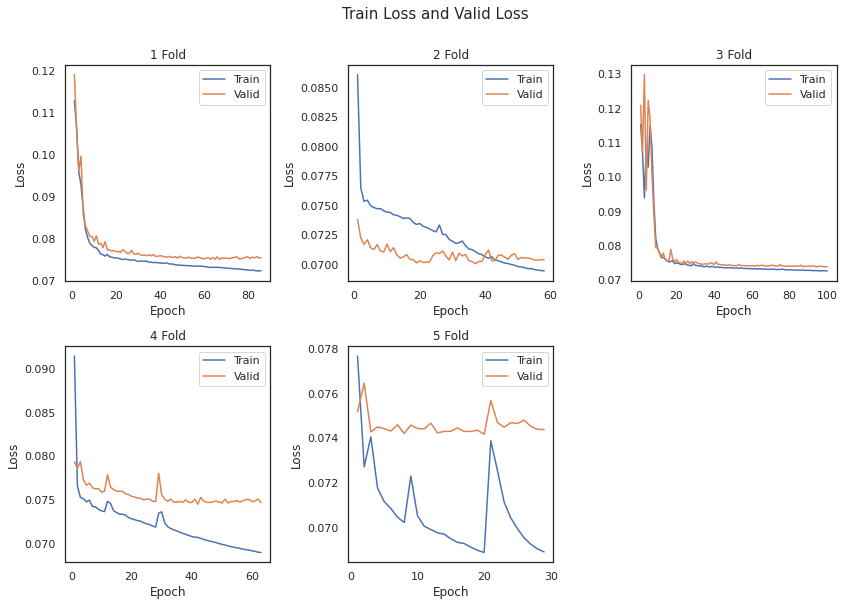

In [268]:
show_loss_plot(fold_train_losses_per_epoch, fold_valid_losses_per_epoch)

#### Test 예측

In [369]:
flow_scaled_all = np.concatenate([flow_scaled[-lstm_args.window:], flow_scaled_test])  # train + test
Xs_test = ts_test2supervised(flow_scaled_all, window=lstm_args.window)   

In [370]:
preds = predict(model, Xs_test, DEVICE, lstm_args)

  0%|          | 0/16 [00:00<?, ?it/s]

In [371]:
preds = minmax_scaler.inverse_transform(preds)
submission.loc[:, 'h0':'h335'] = postprocessing(preds, MIN, MAX)
# submission.to_csv(f'./data/submission_apo_{lstm_args.model_name}.csv', index=False)

- 성능 확인

In [372]:
tmp = test.copy()
for w in range(1, 336):
    tmp[f'flow{w}'] = tmp['flow'].shift(-w)

y_hat = submission.loc[:, 'h0':'h335'].to_numpy()[:8089]
tmp = tmp.dropna().loc[:, 'flow':'flow335'].to_numpy()
mean_absolute_error(tmp, y_hat)

21.997116895961003

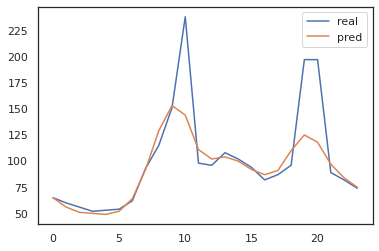

In [373]:
idx = 24*102
plt.plot(tmp[idx][:24], label='real')
plt.plot(submission.loc[idx, 'h0':'h335'].values[:24], label='pred')
plt.legend()

### SCI Net 모델 학습

#### 모델 학습 준비

In [396]:
sci_args = EasyDict({
    'weight_folder_path':'./weights',
    'model_name':'sci',
    'window':336,
    'gap':1,
    'num_classes':336,
    'num_epochs':100,
    'num_folds':5,
    'bs':512,
    'lr':1e-3,
    'lr_gamma':0.97,
    'weight_decay':1e-2,
    'max_norm':1.0,
    'seed':22,
})

In [391]:
Xs, ys = ts_train2supervised(flow_scaled, window=sci_args.window, gap=sci_args.gap, step=sci_args.num_classes)  # s == scaled
Xs, ys = Xs[24*365:], ys[24*365:]  # 2017년 제거
ys = ys.squeeze(2)

In [392]:
early_stopping = EarlyStopping(patience=20,
                               monitor='mae',
                               mode='min',
                               folder_path=sci_args.weight_folder_path,
                               model_name=sci_args.model_name)

In [393]:
# https://github.com/ts-kim/RevIN/blob/master/baselines/SCINet/models/SCINet.py
# Copyright (c) 2022 Electronics and Telecommunications Research Institute (ETRI) 
class Splitting(nn.Module):
    def __init__(self):
        super(Splitting, self).__init__()

    def even(self, x):
        return x[:, ::2, :]

    def odd(self, x):
        return x[:, 1::2, :]

    def forward(self, x):
        """Returns the odd and even part"""
        return (self.even(x), self.odd(x))


class Interactor(nn.Module):
    def __init__(self, in_planes, splitting=True,
                 kernel=5, dropout=0.5, groups=1, hidden_size=1, INN=True):
        super(Interactor, self).__init__()
        self.modified = INN
        self.kernel_size = kernel
        self.dilation = 1
        self.dropout = dropout
        self.hidden_size = hidden_size
        self.groups = groups

        if self.kernel_size % 2 == 0:
            pad_l = self.dilation * (self.kernel_size - 2) // 2 + 1  # by default: stride==1 
            pad_r = self.dilation * (self.kernel_size) // 2 + 1  # by default: stride==1 
        else:
            pad_l = self.dilation * (self.kernel_size - 1) // 2 + 1  # we fix the kernel size of the second layer as 3.
            pad_r = self.dilation * (self.kernel_size - 1) // 2 + 1

        self.splitting = splitting
        self.split = Splitting()

        modules_P = []
        modules_U = []
        modules_psi = []
        modules_phi = []
        prev_size = 1

        size_hidden = self.hidden_size
        modules_P += [
            nn.ReplicationPad1d((pad_l, pad_r)),

            nn.Conv1d(in_planes * prev_size, int(in_planes * size_hidden),
                      kernel_size=self.kernel_size, dilation=self.dilation, stride=1, groups=self.groups),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),

            nn.Dropout(self.dropout),
            nn.Conv1d(int(in_planes * size_hidden), in_planes,
                      kernel_size=3, stride=1, groups=self.groups),
            nn.Tanh()
        ]
        modules_U += [
            nn.ReplicationPad1d((pad_l, pad_r)),
            nn.Conv1d(in_planes * prev_size, int(in_planes * size_hidden),
                      kernel_size=self.kernel_size, dilation=self.dilation, stride=1, groups=self.groups),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(int(in_planes * size_hidden), in_planes,
                      kernel_size=3, stride=1, groups=self.groups),
            nn.Tanh()
        ]

        modules_phi += [
            nn.ReplicationPad1d((pad_l, pad_r)),
            nn.Conv1d(in_planes * prev_size, int(in_planes * size_hidden),
                      kernel_size=self.kernel_size, dilation=self.dilation, stride=1, groups=self.groups),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(int(in_planes * size_hidden), in_planes,
                      kernel_size=3, stride=1, groups=self.groups),
            nn.Tanh()
        ]
        modules_psi += [
            nn.ReplicationPad1d((pad_l, pad_r)),
            nn.Conv1d(in_planes * prev_size, int(in_planes * size_hidden),
                      kernel_size=self.kernel_size, dilation=self.dilation, stride=1, groups=self.groups),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(int(in_planes * size_hidden), in_planes,
                      kernel_size=3, stride=1, groups=self.groups),
            nn.Tanh()
        ]
        self.phi = nn.Sequential(*modules_phi)
        self.psi = nn.Sequential(*modules_psi)
        self.P = nn.Sequential(*modules_P)
        self.U = nn.Sequential(*modules_U)

    def forward(self, x):
        if self.splitting:
            (x_even, x_odd) = self.split(x)
        else:
            (x_even, x_odd) = x

        if self.modified:
            x_even = x_even.permute(0, 2, 1)
            x_odd = x_odd.permute(0, 2, 1)

            d = x_odd.mul(torch.exp(self.phi(x_even)))
            c = x_even.mul(torch.exp(self.psi(x_odd)))

            x_even_update = c + self.U(d)
            x_odd_update = d - self.P(c)
            return (x_even_update, x_odd_update)
        else:
            x_even = x_even.permute(0, 2, 1)
            x_odd = x_odd.permute(0, 2, 1)

            d = x_odd - self.P(x_even)
            c = x_even + self.U(d)
            return (c, d)


class InteractorLevel(nn.Module):
    def __init__(self, in_planes, kernel, dropout, groups , hidden_size, INN):
        super(InteractorLevel, self).__init__()
        self.level = Interactor(in_planes=in_planes, splitting=True,
                 kernel=kernel, dropout=dropout, groups=groups, hidden_size=hidden_size, INN=INN)

    def forward(self, x):
        (x_even_update, x_odd_update) = self.level(x)
        return (x_even_update, x_odd_update)

class LevelSCINet(nn.Module):
    def __init__(self,in_planes, kernel_size, dropout, groups, hidden_size, INN):
        super(LevelSCINet, self).__init__()
        self.interact = InteractorLevel(in_planes=in_planes, kernel=kernel_size, dropout=dropout, groups=groups , hidden_size=hidden_size, INN=INN)

    def forward(self, x):
        (x_even_update, x_odd_update) = self.interact(x)
        return x_even_update.permute(0, 2, 1), x_odd_update.permute(0, 2, 1) #even: B, T, D odd: B, T, D

class SCINet_Tree(nn.Module):
    def __init__(self, in_planes, current_level, kernel_size, dropout, groups, hidden_size, INN):
        super().__init__()
        self.current_level = current_level

        self.workingblock = LevelSCINet(
            in_planes=in_planes,
            kernel_size=kernel_size,
            dropout=dropout,
            groups=groups,
            hidden_size=hidden_size,
            INN=INN)

        if current_level != 0:
            self.SCINet_Tree_odd=SCINet_Tree(in_planes, current_level-1, kernel_size, dropout, groups, hidden_size, INN)
            self.SCINet_Tree_even=SCINet_Tree(in_planes, current_level-1, kernel_size, dropout, groups, hidden_size, INN)
    
    def zip_up_the_pants(self, even, odd):
        even = even.permute(1, 0, 2)
        odd = odd.permute(1, 0, 2)  # L, B, D
        even_len = even.shape[0]
        odd_len = odd.shape[0]
        mlen = min((odd_len, even_len))
        _ = []
        for i in range(mlen):
            _.append(even[i].unsqueeze(0))
            _.append(odd[i].unsqueeze(0))
        if odd_len < even_len: 
            _.append(even[-1].unsqueeze(0))
        return torch.cat(_, 0).permute(1, 0, 2)  # B, L, D
        
    def forward(self, x):
        x_even_update, x_odd_update = self.workingblock(x)
        # We recursively reordered these sub-series. You can run the ./utils/recursive_demo.py to emulate this procedure. 
        if self.current_level == 0:
            return self.zip_up_the_pants(x_even_update, x_odd_update)
        else:
            return self.zip_up_the_pants(self.SCINet_Tree_even(x_even_update), self.SCINet_Tree_odd(x_odd_update))

class EncoderTree(nn.Module):
    def __init__(self, in_planes,  num_levels, kernel_size, dropout, groups, hidden_size, INN):
        super().__init__()
        self.levels=num_levels
        self.SCINet_Tree=SCINet_Tree(
            in_planes=in_planes,
            current_level=num_levels-1,
            kernel_size=kernel_size,
            dropout=dropout ,
            groups=groups,
            hidden_size=hidden_size,
            INN=INN)
        
    def forward(self, x):
        x = self.SCINet_Tree(x)
        return x

class SCINet(nn.Module):
    def __init__(self, output_len, input_len, input_dim=1, hid_size=1, num_stacks=1,
                num_levels=3, concat_len=0, groups=1, kernel=5, dropout=0.5,
                 single_step_output_One=0, input_len_seg=0, positionalE=False, modified=True):
        super(SCINet, self).__init__()
        self.input_dim = input_dim
        self.input_len = input_len
        self.output_len = output_len
        self.hidden_size = hid_size
        self.num_levels = num_levels
        self.groups = groups
        self.modified = modified
        self.kernel_size = kernel
        self.dropout = dropout
        self.single_step_output_One = single_step_output_One
        self.concat_len = concat_len
        self.pe = positionalE
        self.revin = RevIN(input_dim)  # b, s, f means b, f

        self.blocks1 = EncoderTree(
            in_planes=self.input_dim,
            num_levels=self.num_levels,
            kernel_size=self.kernel_size,
            dropout=self.dropout,
            groups=self.groups,
            hidden_size=self.hidden_size,
            INN=modified)

        if num_stacks == 2: # we only implement two stacks at most.
            self.blocks2 = EncoderTree(
                in_planes=self.input_dim,
                num_levels=self.num_levels,
                kernel_size=self.kernel_size,
                dropout=self.dropout,
                groups=self.groups,
                hidden_size=self.hidden_size,
                INN=modified)

        self.stacks = num_stacks

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
        self.projection1 = nn.Conv1d(self.input_len, self.output_len, kernel_size=1, stride=1, bias=False)
        
        if self.single_step_output_One:  # only output the N_th timestep.
            if self.stacks == 2:
                if self.concat_len:
                    self.projection2 = nn.Conv1d(self.concat_len + self.output_len, 1,
                                                kernel_size = 1, bias = False)
                else:
                    self.projection2 = nn.Conv1d(self.input_len + self.output_len, 1,
                                                kernel_size = 1, bias = False)
        else: # output the N timesteps.
            if self.stacks == 2:
                if self.concat_len:
                    self.projection2 = nn.Conv1d(self.concat_len + self.output_len, self.output_len,
                                                kernel_size = 1, bias = False)
                else:
                    self.projection2 = nn.Conv1d(self.input_len + self.output_len, self.output_len,
                                                kernel_size = 1, bias = False)

        # For positional encoding
        self.pe_hidden_size = input_dim
        if self.pe_hidden_size % 2 == 1:
            self.pe_hidden_size += 1
    
        num_timescales = self.pe_hidden_size // 2
        max_timescale = 10000.0
        min_timescale = 1.0

        log_timescale_increment = (
                math.log(float(max_timescale) / float(min_timescale)) /
                max(num_timescales - 1, 1))
        temp = torch.arange(num_timescales, dtype=torch.float32)
        inv_timescales = min_timescale * torch.exp(
            torch.arange(num_timescales, dtype=torch.float32) *
            -log_timescale_increment)
        self.register_buffer('inv_timescales', inv_timescales)
    
    def get_position_encoding(self, x):
        max_length = x.size()[1]
        position = torch.arange(max_length, dtype=torch.float32, device=x.device)  # tensor([0., 1., 2., 3., 4.], device='cuda:0')
        temp1 = position.unsqueeze(1)  # 5 1
        temp2 = self.inv_timescales.unsqueeze(0)  # 1 256
        scaled_time = position.unsqueeze(1) * self.inv_timescales.unsqueeze(0)  # 5 256
        signal = torch.cat([torch.sin(scaled_time), torch.cos(scaled_time)], dim=1)  # [T, C]
        signal = F.pad(signal, (0, 0, 0, self.pe_hidden_size % 2))
        signal = signal.view(1, max_length, self.pe_hidden_size)
        return signal

    def forward(self, x):
        assert self.input_len % (np.power(2, self.num_levels)) == 0  # evenly divided the input length into two parts. (e.g., 32 -> 16 -> 8 -> 4 for 3 levels)
        x = self.revin(x, 'norm')

        if self.pe:
            pe = self.get_position_encoding(x)
            if pe.shape[2] > x.shape[2]:
                x += pe[:, :, :-1]
            else:
                x += self.get_position_encoding(x)
        # the first stack
        res1 = x
        x = self.blocks1(x)
        x += res1
        x = self.projection1(x)

        if self.stacks == 1:
            x = self.revin(x,'denorm')
            return x  # maybe forecast
        elif self.stacks == 2:
            MidOutPut = x  # maybe forecast
            if self.concat_len:
                x = torch.cat((res1[:, -self.concat_len:,:], x), dim=1)
            else:
                x = torch.cat((res1, x), dim=1)

            # the second stack
            res2 = x
            x = self.blocks2(x)
            x += res2
            x = self.projection2(x)
            MidOutPut = self.revin(MidOutPut, 'denorm')
            x = self.revin(x, 'denorm')
            return x, MidOutPut


def get_variable(x):
    x = Variable(x)
    return x.cuda() if torch.cuda.is_available() else x

#### 모델 학습 및 검증

In [397]:
seed_everything(sci_args.seed)
model = SCINet(output_len=sci_args.num_classes, input_len=sci_args.window, input_dim=1, hid_size=1, num_stacks=1,
               num_levels=3, concat_len=0, groups=1, kernel=5, dropout=0.5,
               single_step_output_One=0, positionalE=False, modified=True)

In [398]:
model, fold_train_losses_per_epoch, fold_valid_losses_per_epoch = kfold_cross_validate(model, Xs, ys, loss_fn, 
                                                                                       early_stopping, DEVICE, sci_args)

[1 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.20254  valid loss = 0.17580  valid MAE = 51.80613
[Epoch: 10]  train loss = 0.08856  valid loss = 0.09051  valid MAE = 26.72953
[Epoch: 20]  train loss = 0.07601  valid loss = 0.07860  valid MAE = 23.22678
[Epoch: 30]  train loss = 0.07415  valid loss = 0.07670  valid MAE = 22.66901
[Epoch: 40]  train loss = 0.07374  valid loss = 0.07623  valid MAE = 22.52951
[Epoch: 50]  train loss = 0.07348  valid loss = 0.07604  valid MAE = 22.47542
[Epoch: 60]  train loss = 0.07332  valid loss = 0.07593  valid MAE = 22.44342
[Epoch: 70]  train loss = 0.07329  valid loss = 0.07590  valid MAE = 22.43608
[Epoch: 80]  train loss = 0.07324  valid loss = 0.07589  valid MAE = 22.43055
[Epoch: 90]  train loss = 0.07328  valid loss = 0.07589  valid MAE = 22.43010
[Epoch: 100]  train loss = 0.07319  valid loss = 0.07586  valid MAE = 22.42150
1 Fold -> Best Valid Loss: 0.07586 Valid MAE: 22.42150

[2 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.07645  valid loss = 0.07377  valid MAE = 21.50148
[Epoch: 10]  train loss = 0.07436  valid loss = 0.07273  valid MAE = 21.20273
[Epoch: 20]  train loss = 0.07410  valid loss = 0.07256  valid MAE = 21.15642
[Epoch: 30]  train loss = 0.07395  valid loss = 0.07243  valid MAE = 21.12341
[Epoch: 40]  train loss = 0.07382  valid loss = 0.07234  valid MAE = 21.10013
[Epoch: 50]  train loss = 0.07375  valid loss = 0.07231  valid MAE = 21.09023
[Epoch: 60]  train loss = 0.07369  valid loss = 0.07229  valid MAE = 21.08558
[Epoch: 70]  train loss = 0.07364  valid loss = 0.07226  valid MAE = 21.07766
[Epoch: 80]  train loss = 0.07361  valid loss = 0.07223  valid MAE = 21.06952
[Epoch: 90]  train loss = 0.07359  valid loss = 0.07221  valid MAE = 21.06360
[Epoch: 100]  train loss = 0.07356  valid loss = 0.07220  valid MAE = 21.06065
2 Fold -> Best Valid Loss: 0.07220 Valid MAE: 21.06065

[3 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.07435  valid loss = 0.07543  valid MAE = 22.22166
[Epoch: 10]  train loss = 0.07374  valid loss = 0.07509  valid MAE = 22.12559
[Epoch: 20]  train loss = 0.07332  valid loss = 0.07479  valid MAE = 22.04025
[Epoch: 30]  train loss = 0.07310  valid loss = 0.07467  valid MAE = 22.00969
[Epoch: 40]  train loss = 0.07291  valid loss = 0.07462  valid MAE = 21.99645
[Epoch: 50]  train loss = 0.07294  valid loss = 0.07457  valid MAE = 21.97918
[Epoch: 60]  train loss = 0.07279  valid loss = 0.07450  valid MAE = 21.95867
[Epoch: 70]  train loss = 0.07276  valid loss = 0.07445  valid MAE = 21.94354
[Epoch: 80]  train loss = 0.07278  valid loss = 0.07446  valid MAE = 21.94756
[Epoch: 90]  train loss = 0.07274  valid loss = 0.07442  valid MAE = 21.93699
[Epoch: 100]  train loss = 0.07267  valid loss = 0.07440  valid MAE = 21.93039
3 Fold -> Best Valid Loss: 0.07439 Valid MAE: 21.92760

[4 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.07423  valid loss = 0.07718  valid MAE = 22.64565
[Epoch: 10]  train loss = 0.07361  valid loss = 0.07703  valid MAE = 22.60220
[Epoch: 20]  train loss = 0.07344  valid loss = 0.07685  valid MAE = 22.54909
[Epoch: 30]  train loss = 0.07331  valid loss = 0.07677  valid MAE = 22.52653
[Epoch: 40]  train loss = 0.07322  valid loss = 0.07670  valid MAE = 22.50494
[Epoch: 50]  train loss = 0.07316  valid loss = 0.07668  valid MAE = 22.49936
[Epoch: 60]  train loss = 0.07311  valid loss = 0.07665  valid MAE = 22.49156
[Epoch: 70]  train loss = 0.07307  valid loss = 0.07667  valid MAE = 22.49852
[Epoch: 80]  train loss = 0.07302  valid loss = 0.07663  valid MAE = 22.48534
[Epoch: 90]  train loss = 0.07301  valid loss = 0.07661  valid MAE = 22.48066
[Epoch: 100]  train loss = 0.07300  valid loss = 0.07662  valid MAE = 22.48296
4 Fold -> Best Valid Loss: 0.07659 Valid MAE: 22.47529

[5 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.07468  valid loss = 0.07571  valid MAE = 22.22587
[Epoch: 10]  train loss = 0.07418  valid loss = 0.07568  valid MAE = 22.22177
[Epoch: 20]  train loss = 0.07403  valid loss = 0.07554  valid MAE = 22.18179
[Epoch: 30]  train loss = 0.07393  valid loss = 0.07545  valid MAE = 22.15480
[Epoch: 40]  train loss = 0.07384  valid loss = 0.07542  valid MAE = 22.14592
[Epoch: 50]  train loss = 0.07377  valid loss = 0.07537  valid MAE = 22.13298
[Epoch: 60]  train loss = 0.07372  valid loss = 0.07531  valid MAE = 22.11628
[Epoch: 70]  train loss = 0.07367  valid loss = 0.07531  valid MAE = 22.11560
[Epoch: 80]  train loss = 0.07365  valid loss = 0.07530  valid MAE = 22.11264
[Epoch: 90]  train loss = 0.07362  valid loss = 0.07528  valid MAE = 22.10826
[Epoch: 100]  train loss = 0.07360  valid loss = 0.07527  valid MAE = 22.10434
5 Fold -> Best Valid Loss: 0.07527 Valid MAE: 22.10434

5 Fold Mean Valid Best Loss: 0.07486
5 Fold Mean Valid Accuracy: 21.99788


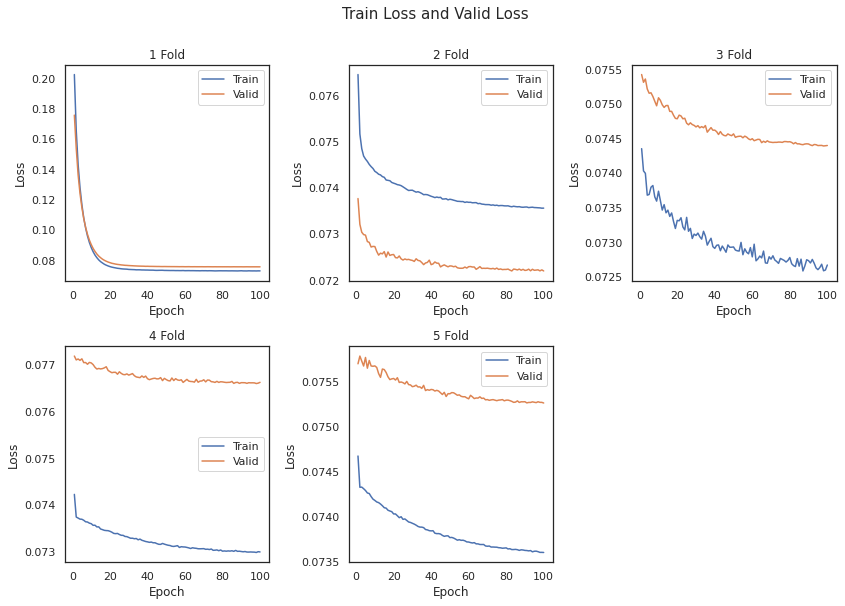

In [399]:
show_loss_plot(fold_train_losses_per_epoch, fold_valid_losses_per_epoch)

#### Test 예측

In [400]:
flow_scaled_all = np.concatenate([flow_scaled[-sci_args.window:], flow_scaled_test])  # train + test
Xs_test = ts_test2supervised(flow_scaled_all, window=sci_args.window)   

In [401]:
preds = predict(model, Xs_test, DEVICE, sci_args)

  0%|          | 0/20 [00:00<?, ?it/s]

In [402]:
preds = minmax_scaler.inverse_transform(preds)
submission.loc[:, 'h0':'h335'] = postprocessing(preds, MIN, MAX)
submission.to_csv(f'./data/submission_apo_{sci_args.model_name}.csv', index=False)

- 성능 확인

In [403]:
tmp = test.copy()
for w in range(1, 336):
    tmp[f'flow{w}'] = tmp['flow'].shift(-w)

y_hat = submission.loc[:, 'h0':'h335'].to_numpy()[:8089]
tmp = tmp.dropna().loc[:, 'flow':'flow335'].to_numpy()
mean_absolute_error(tmp, y_hat)

22.46958575431656

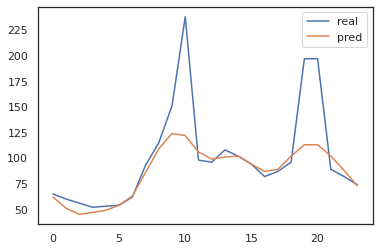

In [404]:
idx = 24*102
plt.plot(tmp[idx][:24], label='real')
plt.plot(submission.loc[idx, 'h0':'h335'].values[:24], label='pred')
plt.legend()

### DLinear 모델 학습

#### 모델 학습 준비

In [374]:
dlinear_args = EasyDict({
    'weight_folder_path':'./weights',
    'model_name':'dlinear',
    'window':336,
    'gap':1,
    'num_classes':336,
    'num_epochs':100,
    'num_folds':5,
    'bs':512,
    'lr':1e-2,
    'lr_gamma':0.98,
    'weight_decay':1e-2,
    'max_norm':1.0,
    'seed':22,
    'seq_len':336,
    'pred_len':336,
    'enc_in':1,
    'individual':False,
})

In [375]:
create_folder(dlinear_args.weight_folder_path)

In [376]:
Xs, ys = ts_train2supervised(flow_scaled, window=dlinear_args.window, gap=dlinear_args.gap, step=dlinear_args.num_classes)  # s == scaled
Xs, ys = Xs[24*365:], ys[24*365:]  # 2017년 제거
ys = ys.squeeze(2)

In [377]:
early_stopping = EarlyStopping(patience=20,
                               monitor='mae',
                               mode='min',
                               folder_path=dlinear_args.weight_folder_path,
                               model_name=dlinear_args.model_name)

In [378]:
# ref: https://github.com/cure-lab/LTSF-Linear/blob/main/models/DLinear.py
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class DLinear(nn.Module):
    """
    Decomposition-Linear
    """
    def __init__(self, configs):
        super(DLinear, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.revin_layer = RevIN(configs.enc_in)  # 시간에 따라 변하는 시계열의 평균과 분산을 스케일링

        # Decompsition Kernel Size
        kernel_size = 25
        self.decompsition = series_decomp(kernel_size)
        self.individual = configs.individual
        self.channels = configs.enc_in

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()
            
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len, self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len, self.pred_len))

                # Use this two lines if you want to visualize the weights
                # self.Linear_Seasonal[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len, self.seq_len]))
                # self.Linear_Trend[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len, self.seq_len]))
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len, self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len, self.pred_len)
            
            # Use this two lines if you want to visualize the weights
            # self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
            # self.Linear_Trend.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    def forward(self, x):
        x = self.revin_layer(x, 'norm')
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len], dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),self.pred_len],dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        x = self.revin_layer(x, 'denorm')
        return x.permute(0,2,1) # to [Batch, Output length, Channel]

#### 모델 학습 및 검증

In [379]:
seed_everything(dlinear_args.seed)
model = DLinear(dlinear_args)

In [380]:
model, fold_train_losses_per_epoch, fold_valid_losses_per_epoch = kfold_cross_validate(model, Xs, ys, loss_fn, 
                                                                                       early_stopping, DEVICE, dlinear_args)

[1 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.11251  valid loss = 0.09953  valid MAE = 29.40172
[Epoch: 10]  train loss = 0.07679  valid loss = 0.07951  valid MAE = 23.49200
[Epoch: 20]  train loss = 0.07587  valid loss = 0.07859  valid MAE = 23.21918
[Epoch: 30]  train loss = 0.07534  valid loss = 0.07806  valid MAE = 23.06527
[Epoch: 40]  train loss = 0.07499  valid loss = 0.07756  valid MAE = 22.91986
[Epoch: 50]  train loss = 0.07453  valid loss = 0.07729  valid MAE = 22.84171
[Epoch: 60]  train loss = 0.07421  valid loss = 0.07705  valid MAE = 22.77053
[Epoch: 70]  train loss = 0.07400  valid loss = 0.07685  valid MAE = 22.71248
[Epoch: 80]  train loss = 0.07377  valid loss = 0.07677  valid MAE = 22.68796
[Epoch: 90]  train loss = 0.07366  valid loss = 0.07651  valid MAE = 22.61208
[Epoch: 100]  train loss = 0.07344  valid loss = 0.07662  valid MAE = 22.64488
1 Fold -> Best Valid Loss: 0.07646 Valid MAE: 22.59766

[2 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.09459  valid loss = 0.08228  valid MAE = 24.00872
[Epoch: 10]  train loss = 0.07734  valid loss = 0.07545  valid MAE = 22.00116
[Epoch: 20]  train loss = 0.07688  valid loss = 0.07488  valid MAE = 21.83250
[Epoch: 30]  train loss = 0.07625  valid loss = 0.07421  valid MAE = 21.64609
[Epoch: 40]  train loss = 0.07588  valid loss = 0.07394  valid MAE = 21.57038
[Epoch: 50]  train loss = 0.07547  valid loss = 0.07349  valid MAE = 21.43341
[Epoch: 60]  train loss = 0.07515  valid loss = 0.07333  valid MAE = 21.38468
[Epoch: 70]  train loss = 0.07492  valid loss = 0.07307  valid MAE = 21.31231
[Epoch: 80]  train loss = 0.07468  valid loss = 0.07292  valid MAE = 21.26271
[Epoch: 90]  train loss = 0.07456  valid loss = 0.07284  valid MAE = 21.24262
[Epoch: 100]  train loss = 0.07440  valid loss = 0.07273  valid MAE = 21.20654
2 Fold -> Best Valid Loss: 0.07273 Valid MAE: 21.20654

[3 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.08913  valid loss = 0.08506  valid MAE = 25.04603
[Epoch: 10]  train loss = 0.07974  valid loss = 0.08230  valid MAE = 24.23008
[Epoch: 20]  train loss = 0.07837  valid loss = 0.08035  valid MAE = 23.65457
[Epoch: 30]  train loss = 0.07766  valid loss = 0.07943  valid MAE = 23.39352
[Epoch: 40]  train loss = 0.07647  valid loss = 0.07822  valid MAE = 23.04142
[Epoch: 50]  train loss = 0.07618  valid loss = 0.07749  valid MAE = 22.80981
[Epoch: 60]  train loss = 0.07537  valid loss = 0.07688  valid MAE = 22.64132
[Epoch: 70]  train loss = 0.07487  valid loss = 0.07634  valid MAE = 22.48220
[Epoch: 80]  train loss = 0.07459  valid loss = 0.07593  valid MAE = 22.35980
[Epoch: 90]  train loss = 0.07435  valid loss = 0.07561  valid MAE = 22.27000
[Epoch: 100]  train loss = 0.07406  valid loss = 0.07544  valid MAE = 22.22765
3 Fold -> Best Valid Loss: 0.07546 Valid MAE: 22.22739

[4 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.08772  valid loss = 0.08205  valid MAE = 24.03980
[Epoch: 10]  train loss = 0.07734  valid loss = 0.08075  valid MAE = 23.66957
[Epoch: 20]  train loss = 0.07664  valid loss = 0.08017  valid MAE = 23.49756
[Epoch: 30]  train loss = 0.07612  valid loss = 0.07962  valid MAE = 23.34511
[Epoch: 40]  train loss = 0.07559  valid loss = 0.07900  valid MAE = 23.16686
[Epoch: 50]  train loss = 0.07519  valid loss = 0.07855  valid MAE = 23.03497
[Epoch: 60]  train loss = 0.07489  valid loss = 0.07832  valid MAE = 22.97016
[Epoch: 70]  train loss = 0.07464  valid loss = 0.07796  valid MAE = 22.86676
[Epoch: 80]  train loss = 0.07441  valid loss = 0.07767  valid MAE = 22.78173
[Epoch: 90]  train loss = 0.07420  valid loss = 0.07749  valid MAE = 22.73268
[Epoch: 100]  train loss = 0.07406  valid loss = 0.07750  valid MAE = 22.73193
4 Fold -> Best Valid Loss: 0.07745 Valid MAE: 22.72018

[5 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.08639  valid loss = 0.08010  valid MAE = 23.52003
[Epoch: 10]  train loss = 0.07786  valid loss = 0.07951  valid MAE = 23.34890
[Epoch: 20]  train loss = 0.07722  valid loss = 0.07875  valid MAE = 23.12455
[Epoch: 30]  train loss = 0.07667  valid loss = 0.07819  valid MAE = 22.94683
[Epoch: 40]  train loss = 0.07619  valid loss = 0.07768  valid MAE = 22.79905
[Epoch: 50]  train loss = 0.07581  valid loss = 0.07731  valid MAE = 22.68397
[Epoch: 60]  train loss = 0.07555  valid loss = 0.07695  valid MAE = 22.58488
[Epoch: 70]  train loss = 0.07528  valid loss = 0.07678  valid MAE = 22.53426
[Epoch: 80]  train loss = 0.07508  valid loss = 0.07653  valid MAE = 22.45928
[Epoch: 90]  train loss = 0.07489  valid loss = 0.07638  valid MAE = 22.41740
[Epoch: 100]  train loss = 0.07473  valid loss = 0.07621  valid MAE = 22.36754
5 Fold -> Best Valid Loss: 0.07621 Valid MAE: 22.36754

5 Fold Mean Valid Best Loss: 0.07566
5 Fold Mean Valid Accuracy: 22.22386


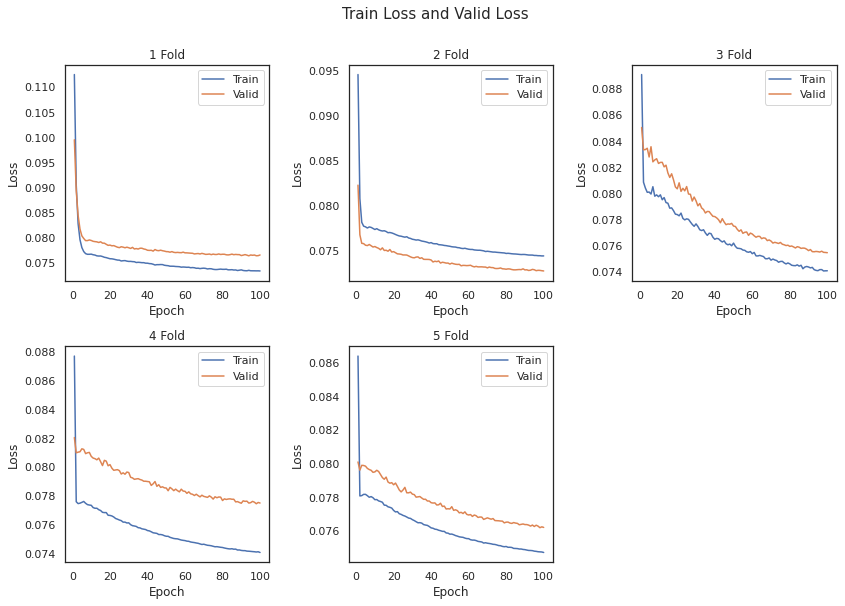

In [381]:
show_loss_plot(fold_train_losses_per_epoch, fold_valid_losses_per_epoch)

#### Test 예측

In [382]:
flow_scaled_all = np.concatenate([flow_scaled[-dlinear_args.window:], flow_scaled_test])  # train + test
Xs_test = ts_test2supervised(flow_scaled_all, window=dlinear_args.window)   

In [383]:
preds = predict(model, Xs_test, DEVICE, dlinear_args)

  0%|          | 0/16 [00:00<?, ?it/s]

In [384]:
preds = minmax_scaler.inverse_transform(preds)
submission.loc[:, 'h0':'h335'] = postprocessing(preds, MIN, MAX)
# submission.to_csv(f'./data/submission_apo_{dlinear_args.model_name}.csv', index=False)

- 성능 확인

In [385]:
tmp = test.copy()
for w in range(1, 336):
    tmp[f'flow{w}'] = tmp['flow'].shift(-w)

y_hat = submission.loc[:, 'h0':'h335'].to_numpy()[:8089]
tmp = tmp.dropna().loc[:, 'flow':'flow335'].to_numpy()
mean_absolute_error(tmp, y_hat)

22.538765901959746

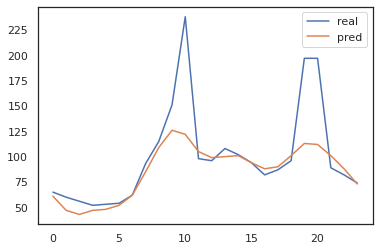

In [386]:
idx = 24*102
plt.plot(tmp[idx][:24], label='real')
plt.plot(submission.loc[idx, 'h0':'h335'].values[:24], label='pred')
plt.legend()

### NLinear 모델 학습


#### 모델 학습 준비

In [351]:
nlinear_args = EasyDict({
    'weight_folder_path':'./weights',
    'model_name':'nlinear',
    'window':336,
    'gap':1,
    'num_classes':336,
    'num_epochs':100,
    'num_folds':5,
    'bs':512,
    'lr':1e-2,
    'lr_gamma':0.98,
    'weight_decay':1e-2,
    'max_norm':1.0,
    'seed':22,
    'seq_len':336,
    'pred_len':336,
    'enc_in':1,
    'individual':False,
})

In [352]:
create_folder(nlinear_args.weight_folder_path)

In [353]:
Xs, ys = ts_train2supervised(flow_scaled, window=nlinear_args.window, gap=nlinear_args.gap, step=nlinear_args.num_classes)  # s == scaled
ys = ys.squeeze(2)
Xs, ys = Xs[24*365:], ys[24*365:]  # 2017년 제거

In [354]:
early_stopping = EarlyStopping(patience=20,
                               monitor='mae',
                               mode='min',
                               folder_path=nlinear_args.weight_folder_path,
                               model_name=nlinear_args.model_name)

In [355]:
class NLinear(nn.Module):
    """
    Normalization-Linear
    """
    def __init__(self, configs):
        super(NLinear, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.Linear = nn.Linear(self.seq_len, self.pred_len)
        self.revin_layer = RevIN(configs.enc_in)  # 시간에 따라 변하는 시계열의 평균과 분산을 스케일링
        # Use this line if you want to visualize the weights
        # self.Linear.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    def forward(self, x):
        x = self.revin_layer(x, 'norm')
        # x: [Batch, Input length, Channel]
        seq_last = x[:, -1:, :].detach()
        x = x - seq_last
        x = self.Linear(x.permute(0, 2, 1)).permute(0, 2, 1)
        x = x + seq_last
        x = self.revin_layer(x, 'denorm')
        return x # [Batch, Output length, Channel]

#### 모델 학습 및 검증

In [356]:
seed_everything(nlinear_args.seed)
model = NLinear(nlinear_args)

In [357]:
model, fold_train_losses_per_epoch, fold_valid_losses_per_epoch = kfold_cross_validate(model, Xs, ys, loss_fn, 
                                                                                       early_stopping, DEVICE, nlinear_args)

[1 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.18359  valid loss = 0.15244  valid MAE = 45.01435
[Epoch: 10]  train loss = 0.07866  valid loss = 0.08236  valid MAE = 24.33033
[Epoch: 20]  train loss = 0.07614  valid loss = 0.07943  valid MAE = 23.47250
[Epoch: 30]  train loss = 0.07529  valid loss = 0.07849  valid MAE = 23.19494
[Epoch: 40]  train loss = 0.07472  valid loss = 0.07801  valid MAE = 23.05522
[Epoch: 50]  train loss = 0.07423  valid loss = 0.07742  valid MAE = 22.88068
[Epoch: 60]  train loss = 0.07414  valid loss = 0.07729  valid MAE = 22.84271
[Epoch: 70]  train loss = 0.07375  valid loss = 0.07712  valid MAE = 22.79062
[Epoch: 80]  train loss = 0.07351  valid loss = 0.07677  valid MAE = 22.68732
[Epoch: 90]  train loss = 0.07346  valid loss = 0.07654  valid MAE = 22.62105
[Epoch: 100]  train loss = 0.07327  valid loss = 0.07657  valid MAE = 22.62769
1 Fold -> Best Valid Loss: 0.07648 Valid MAE: 22.60369

[2 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.15746  valid loss = 0.11696  valid MAE = 34.16540
[Epoch: 10]  train loss = 0.07762  valid loss = 0.07641  valid MAE = 22.28943
[Epoch: 20]  train loss = 0.07709  valid loss = 0.07632  valid MAE = 22.26409
[Epoch: 30]  train loss = 0.07607  valid loss = 0.07468  valid MAE = 21.78068
[Epoch: 40]  train loss = 0.07561  valid loss = 0.07403  valid MAE = 21.59319
[Epoch: 50]  train loss = 0.07522  valid loss = 0.07361  valid MAE = 21.46829
[Epoch: 60]  train loss = 0.07483  valid loss = 0.07336  valid MAE = 21.39580
[Epoch: 70]  train loss = 0.07460  valid loss = 0.07314  valid MAE = 21.32967
[Epoch: 80]  train loss = 0.07445  valid loss = 0.07316  valid MAE = 21.33386
[Epoch: 90]  train loss = 0.07430  valid loss = 0.07292  valid MAE = 21.26165
[Epoch: 100]  train loss = 0.07423  valid loss = 0.07287  valid MAE = 21.25010
2 Fold -> Best Valid Loss: 0.07280 Valid MAE: 21.22632

[3 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.13017  valid loss = 0.09265  valid MAE = 27.27999
[Epoch: 10]  train loss = 0.08063  valid loss = 0.09128  valid MAE = 26.88215
[Epoch: 20]  train loss = 0.07724  valid loss = 0.08216  valid MAE = 24.19985
[Epoch: 30]  train loss = 0.07654  valid loss = 0.08013  valid MAE = 23.60848
[Epoch: 40]  train loss = 0.07561  valid loss = 0.07923  valid MAE = 23.34295
[Epoch: 50]  train loss = 0.07669  valid loss = 0.07901  valid MAE = 23.26723
[Epoch: 60]  train loss = 0.07508  valid loss = 0.07741  valid MAE = 22.79982
[Epoch: 70]  train loss = 0.07428  valid loss = 0.07715  valid MAE = 22.72191
[Epoch: 80]  train loss = 0.07432  valid loss = 0.07658  valid MAE = 22.55408
[Epoch: 90]  train loss = 0.07410  valid loss = 0.07614  valid MAE = 22.42522
[Epoch: 100]  train loss = 0.07366  valid loss = 0.07609  valid MAE = 22.41473
3 Fold -> Best Valid Loss: 0.07579 Valid MAE: 22.31734

[4 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.12082  valid loss = 0.08738  valid MAE = 25.61667
[Epoch: 10]  train loss = 0.07843  valid loss = 0.08185  valid MAE = 23.99996
[Epoch: 20]  train loss = 0.07699  valid loss = 0.08173  valid MAE = 23.96538
[Epoch: 30]  train loss = 0.07599  valid loss = 0.07979  valid MAE = 23.40199
[Epoch: 40]  train loss = 0.07534  valid loss = 0.07921  valid MAE = 23.23135
[Epoch: 50]  train loss = 0.07470  valid loss = 0.07832  valid MAE = 22.97319
[Epoch: 60]  train loss = 0.07447  valid loss = 0.07824  valid MAE = 22.94943
[Epoch: 70]  train loss = 0.07425  valid loss = 0.07775  valid MAE = 22.80752
[Epoch: 80]  train loss = 0.07411  valid loss = 0.07784  valid MAE = 22.83323
[Epoch: 90]  train loss = 0.07399  valid loss = 0.07776  valid MAE = 22.80956
[Epoch: 100]  train loss = 0.07389  valid loss = 0.07759  valid MAE = 22.76091
4 Fold -> Best Valid Loss: 0.07744 Valid MAE: 22.71608

[5 / 5] Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.11790  valid loss = 0.08510  valid MAE = 24.99242
[Epoch: 10]  train loss = 0.07914  valid loss = 0.08117  valid MAE = 23.83688
[Epoch: 20]  train loss = 0.07764  valid loss = 0.07977  valid MAE = 23.42031
[Epoch: 30]  train loss = 0.07663  valid loss = 0.07825  valid MAE = 22.96843
[Epoch: 40]  train loss = 0.07591  valid loss = 0.07771  valid MAE = 22.80979
[Epoch: 50]  train loss = 0.07551  valid loss = 0.07711  valid MAE = 22.63563
[Epoch: 60]  train loss = 0.07519  valid loss = 0.07703  valid MAE = 22.61142
[Epoch: 70]  train loss = 0.07495  valid loss = 0.07649  valid MAE = 22.45029
[Epoch: 80]  train loss = 0.07478  valid loss = 0.07652  valid MAE = 22.45210
[Epoch: 90]  train loss = 0.07463  valid loss = 0.07639  valid MAE = 22.41818
[Epoch: 100]  train loss = 0.07452  valid loss = 0.07636  valid MAE = 22.41053
5 Fold -> Best Valid Loss: 0.07611 Valid MAE: 22.33537

5 Fold Mean Valid Best Loss: 0.07572
5 Fold Mean Valid Accuracy: 22.23976


#### Test 예측

In [358]:
flow_scaled_all = np.concatenate([flow_scaled[-nlinear_args.window:], flow_scaled_test])  # train + test
Xs_test = ts_test2supervised(flow_scaled_all, window=nlinear_args.window)   

In [359]:
preds = predict(model, Xs_test, DEVICE, nlinear_args)

  0%|          | 0/16 [00:00<?, ?it/s]

In [360]:
preds = minmax_scaler.inverse_transform(preds)
submission.loc[:, 'h0':'h335'] = postprocessing(preds, MIN, MAX)
# submission.to_csv(f'./data/submission_apo_{nlinear_args.model_name}.csv', index=False)

- 성능 확인

In [361]:
tmp = test.copy()
for w in range(1, 336):
    tmp[f'flow{w}'] = tmp['flow'].shift(-w)

y_hat = submission.loc[:, 'h0':'h335'].to_numpy()[:8089]
tmp = tmp.dropna().loc[:, 'flow':'flow335'].to_numpy()
mean_absolute_error(tmp, y_hat)

22.541762328617935

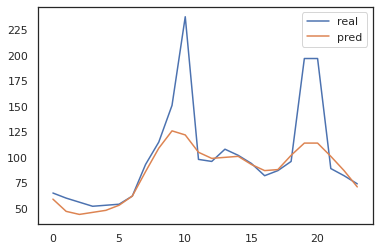

In [367]:
idx = 24*102
plt.plot(tmp[idx][:24], label='real')
plt.plot(submission.loc[idx, 'h0':'h335'].values[:24], label='pred')
plt.legend()